**Quatrième réseau** :  
     - Similaire au troisième, mais avec des images de 32x32 pixels  
    - Les images sont redimensionnées à 32x32 pixels.  
    - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 3
epochs = 50
crossValidationSplit = 10

In [7]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [8]:
def charger_images_par_format_cv2(chemin):
    """
    Charge des images d'un chemin spécifique dont les noms suivent le format y_x.jpeg.
    Les images sont lues en niveaux de gris, leur taille originale est respectée, 
    et leur dimension du canal est explicitement ajoutée pour éviter toute perte d'information.
    
    Paramètres :
    chemin (str) : Chemin de base où chercher les images.
    
    Retourne :
    X (np.array) : Liste des images traitées.
    y (np.array) : Liste des labels extraits des noms des fichiers.
    input_shape (tuple) : Taille des images (hauteur, largeur, canaux).
    """
    X = []
    y = []
    dimensions = None

    # Chemin pour les images respectant le format spécifié
    chemin_images = rf'{chemin}\*_*.jpeg'

    # Parcourir toutes les images correspondant au modèle
    for fichier in glob.glob(chemin_images):
        # Lire l'image en niveaux de gris
        image = cv2.imread(fichier, cv2.IMREAD_GRAYSCALE)
        if image is not None:  # Vérifier si l'image a été correctement chargée
            # Ajouter une dimension pour le canal
            image = np.expand_dims(image, axis=-1)
            X.append(image)
            
            # Vérifier et conserver la taille de la première image
            if dimensions is None:
                hauteur, largeur = image.shape[:2]
                dimensions = (hauteur, largeur, 1)  # Ajouter explicitement le canal (gris)
            
            # Extraire le label y depuis le nom de fichier
            nom = fichier.split('\\')[-1].replace('.jpeg', '')  # Récupérer le nom sans extension
            label = int(nom.split('_')[0])  # Extraire 'y' avant le '_'
            
            y.append(label)
        else:
            print(f"Impossible de lire l'image : {fichier}")

    # Convertir X et y en tableaux numpy
    return np.array(X), np.array(y), dimensions

In [9]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")

(5832, 32, 32, 1) échantillons d'entraînement
(32, 32, 1) input_shape
50 epochs


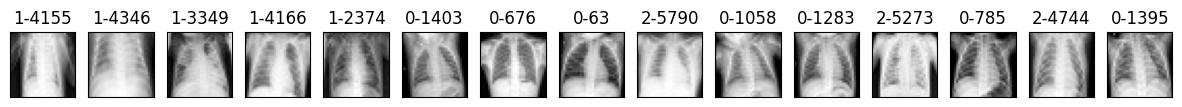

x_train (5248, 32, 32, 1) x_test (584, 32, 32, 1)
y_train (5248,) y_test (584,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 3s - 40ms/step - accuracy: 0.4929 - loss: 1.0399 - val_accuracy: 0.5462 - val_loss: 0.9155
Epoch 2/50
82/82 - 1s - 14ms/step - accuracy: 0.6614 - loss: 0.7707 - val_accuracy: 0.7483 - val_loss: 0.5909
Epoch 3/50
82/82 - 1s - 14ms/step - accuracy: 0.7243 - loss: 0.6209 - val_accuracy: 0.7620 - val_loss: 0.5492
Epoch 4/50
82/82 - 1s - 14ms/step - accuracy: 0.7420 - loss: 0.5953 - val_accuracy: 0.7877 - val_loss: 0.5137
Epoch 5/50
82/82 - 1s - 14ms/step - accuracy: 0.7624 - loss: 0.5494 - val_accuracy: 0.7860 - val_loss: 0.5148
Epoch 6/50
82/82 - 1s - 14ms/step - accuracy: 0.7729 - loss: 0.5319 - val_accuracy: 0.7842 - val_loss: 0.4803
Epoch 7/50
82/82 - 1s - 14ms/step - accuracy: 0.7833 - loss: 0.5056 - val_accuracy: 0.7979 - val_loss: 0.4893
Epoch 8/50
82/82 - 1s - 14ms/step - accuracy: 0.7820 - loss: 0.5052 - val_accuracy: 0.7962 - val_loss: 0.4803
Epoch 9/50
82/82 - 1s - 14ms/step - accuracy: 0.7872 - loss: 0.4900 - val_accuracy: 0.8099 - val_loss: 0.4653
Epoch

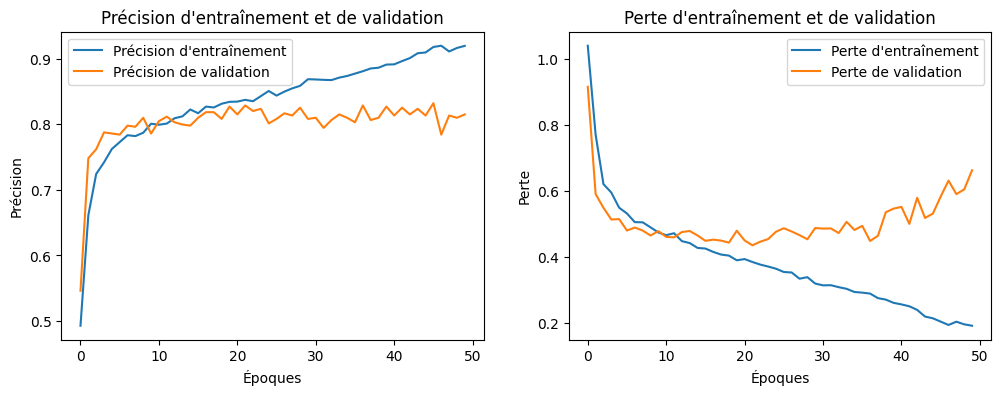

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8810 - loss: 0.4389
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 1:
perte: 0.66 précision: 0.82
AUC 0.9226
Prédictions
Counter({np.int64(1): 300, np.int64(0): 154, np.int64(2): 130}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.94      0.91      0.92       158
Pneumonia_bacteriana       0.81      0.88      0.84       277
     Pneumonia_viral       0.68      0.60      0.64       149

            accuracy                           0.82       584
           macro avg       0.81      0.80      0.80       584
        weighted avg       0.81      0.82      0.81       584

Matrice de confusion


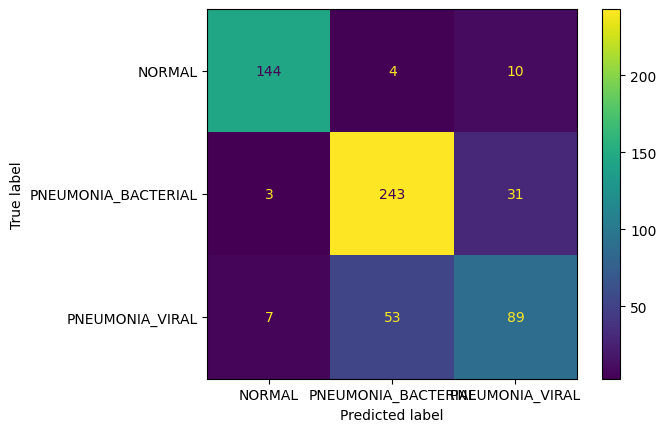

x_train (5248, 32, 32, 1) x_test (584, 32, 32, 1)
y_train (5248,) y_test (584,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 3s - 34ms/step - accuracy: 0.4971 - loss: 1.0333 - val_accuracy: 0.6164 - val_loss: 0.8610
Epoch 2/50
82/82 - 1s - 14ms/step - accuracy: 0.6679 - loss: 0.7528 - val_accuracy: 0.7038 - val_loss: 0.6512
Epoch 3/50
82/82 - 1s - 15ms/step - accuracy: 0.7311 - loss: 0.6150 - val_accuracy: 0.7432 - val_loss: 0.5998
Epoch 4/50
82/82 - 1s - 14ms/step - accuracy: 0.7563 - loss: 0.5734 - val_accuracy: 0.7654 - val_loss: 0.5557
Epoch 5/50
82/82 - 1s - 14ms/step - accuracy: 0.7731 - loss: 0.5309 - val_accuracy: 0.7825 - val_loss: 0.5531
Epoch 6/50
82/82 - 1s - 14ms/step - accuracy: 0.7879 - loss: 0.5100 - val_accuracy: 0.7517 - val_loss: 0.5711
Epoch 7/50
82/82 - 1s - 14ms/step - accuracy: 0.7912 - loss: 0.5021 - val_accuracy: 0.7825 - val_loss: 0.5176
Epoch 8/50
82/82 - 1s - 14ms/step - accuracy: 0.7955 - loss: 0.4804 - val_accuracy: 0.7962 - val_loss: 0.5051
Epoch 9/50
82/82 - 1s - 14ms/step - accuracy: 0.8045 - loss: 0.4693 - val_accuracy: 0.7705 - val_loss: 0.5120
Epoch

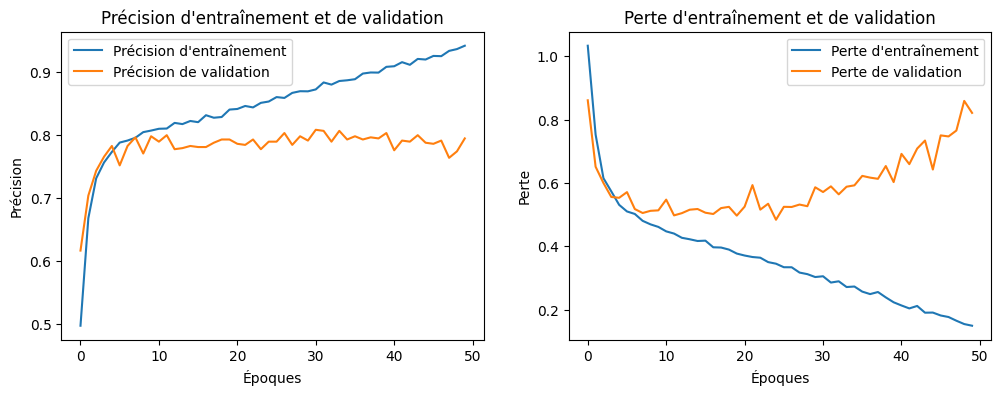

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8518 - loss: 0.6408
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 2:
perte: 0.82 précision: 0.79
AUC 0.9169
Prédictions
Counter({np.int64(1): 266, np.int64(2): 160, np.int64(0): 158}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.90      0.90      0.90       158
Pneumonia_bacteriana       0.84      0.81      0.83       277
     Pneumonia_viral       0.61      0.66      0.63       149

            accuracy                           0.79       584
           macro avg       0.78      0.79      0.79       584
        weighted avg       0.80      0.79      0.80       584

Matrice de confusion


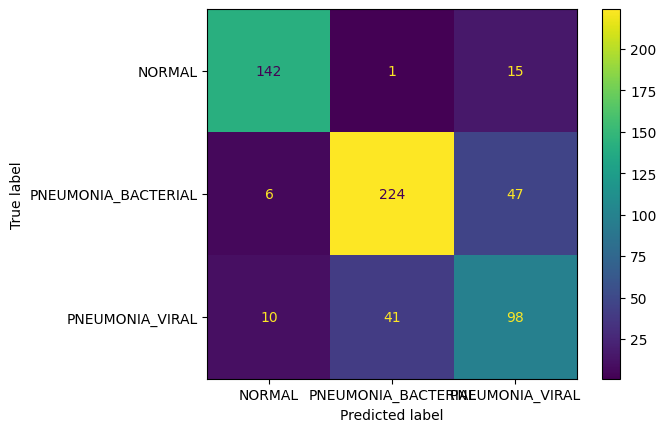

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 35ms/step - accuracy: 0.4978 - loss: 1.0284 - val_accuracy: 0.5060 - val_loss: 1.0613
Epoch 2/50
83/83 - 1s - 15ms/step - accuracy: 0.6698 - loss: 0.7399 - val_accuracy: 0.7376 - val_loss: 0.6107
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.7192 - loss: 0.6328 - val_accuracy: 0.7324 - val_loss: 0.6064
Epoch 4/50
83/83 - 1s - 14ms/step - accuracy: 0.7533 - loss: 0.5890 - val_accuracy: 0.7358 - val_loss: 0.5820
Epoch 5/50
83/83 - 1s - 14ms/step - accuracy: 0.7720 - loss: 0.5488 - val_accuracy: 0.7667 - val_loss: 0.5291
Epoch 6/50
83/83 - 1s - 14ms/step - accuracy: 0.7765 - loss: 0.5293 - val_accuracy: 0.7650 - val_loss: 0.5262
Epoch 7/50
83/83 - 1s - 14ms/step - accuracy: 0.7710 - loss: 0.5255 - val_accuracy: 0.7667 - val_loss: 0.5204
Epoch 8/50
83/83 - 1s - 14ms/step - accuracy: 0.7906 - loss: 0.5022 - val_accuracy: 0.7719 - val_loss: 0.5247
Epoch 9/50
83/83 - 1s - 14ms/step - accuracy: 0.7988 - loss: 0.4845 - val_accuracy: 0.7719 - val_loss: 0.5291
Epoch

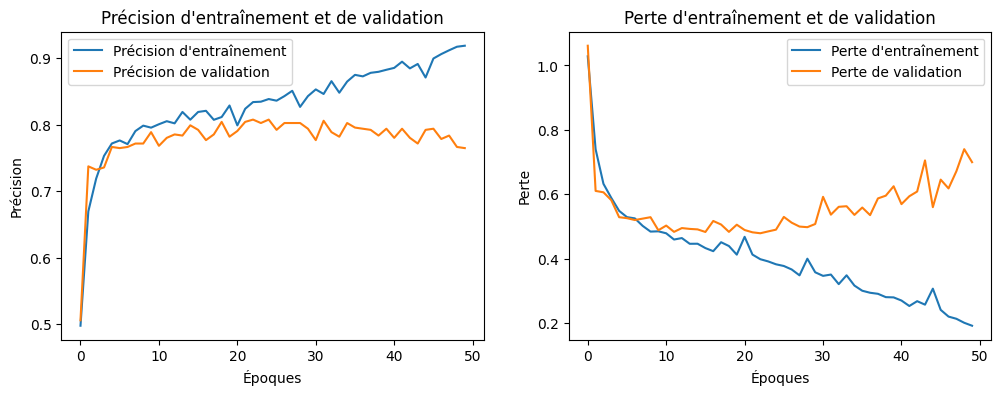

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8218 - loss: 0.5687
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Partition numéro 3:
perte: 0.70 précision: 0.77
AUC 0.9127
Prédictions
Counter({np.int64(1): 249, np.int64(2): 169, np.int64(0): 165}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.88      0.92      0.90       158
Pneumonia_bacteriana       0.82      0.74      0.78       277
     Pneumonia_viral       0.56      0.64      0.60       148

            accuracy                           0.77       583
           macro avg       0.76      0.77      0.76       583
        weighted avg       0.77      0.77      0.77       583

Matrice de confusion


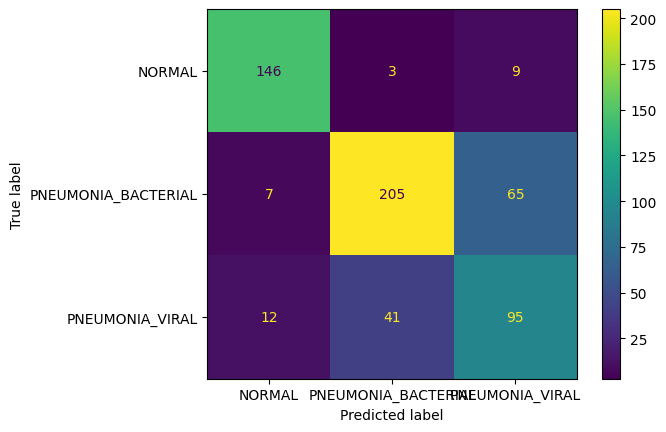

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 35ms/step - accuracy: 0.5224 - loss: 1.0005 - val_accuracy: 0.6792 - val_loss: 0.7292
Epoch 2/50
83/83 - 1s - 14ms/step - accuracy: 0.6799 - loss: 0.7182 - val_accuracy: 0.7410 - val_loss: 0.6108
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.7249 - loss: 0.6188 - val_accuracy: 0.7547 - val_loss: 0.5406
Epoch 4/50
83/83 - 1s - 14ms/step - accuracy: 0.7468 - loss: 0.5895 - val_accuracy: 0.7736 - val_loss: 0.5290
Epoch 5/50
83/83 - 1s - 14ms/step - accuracy: 0.7521 - loss: 0.5734 - val_accuracy: 0.7925 - val_loss: 0.5054
Epoch 6/50
83/83 - 1s - 15ms/step - accuracy: 0.7714 - loss: 0.5386 - val_accuracy: 0.8096 - val_loss: 0.4737
Epoch 7/50
83/83 - 1s - 14ms/step - accuracy: 0.7794 - loss: 0.5263 - val_accuracy: 0.8062 - val_loss: 0.4615
Epoch 8/50
83/83 - 1s - 15ms/step - accuracy: 0.7878 - loss: 0.5065 - val_accuracy: 0.8062 - val_loss: 0.4645
Epoch 9/50
83/83 - 1s - 14ms/step - accuracy: 0.7845 - loss: 0.5069 - val_accuracy: 0.7907 - val_loss: 0.4774
Epoch

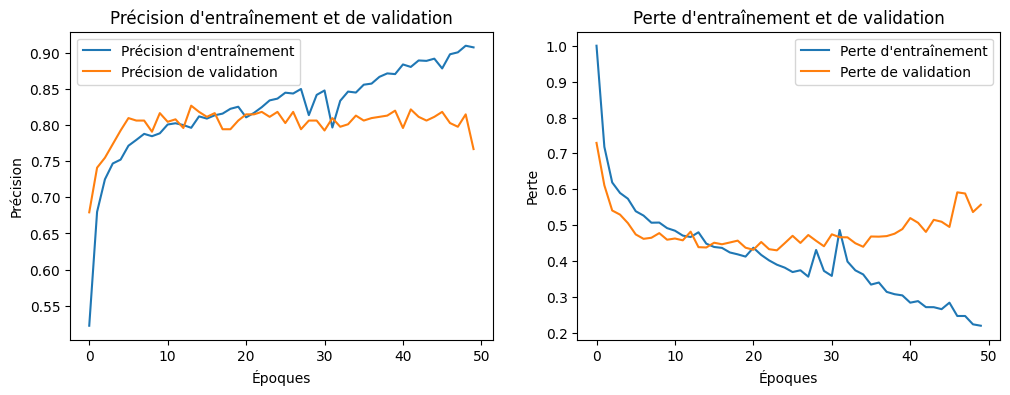

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8151 - loss: 0.4847
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 4:
perte: 0.56 précision: 0.77
AUC 0.9132
Prédictions
Counter({np.int64(1): 258, np.int64(2): 174, np.int64(0): 151}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.93      0.89      0.91       158
Pneumonia_bacteriana       0.81      0.76      0.79       277
     Pneumonia_viral       0.55      0.65      0.60       148

            accuracy                           0.77       583
           macro avg       0.77      0.77      0.76       583
        weighted avg       0.78      0.77      0.77       583

Matrice de confusion


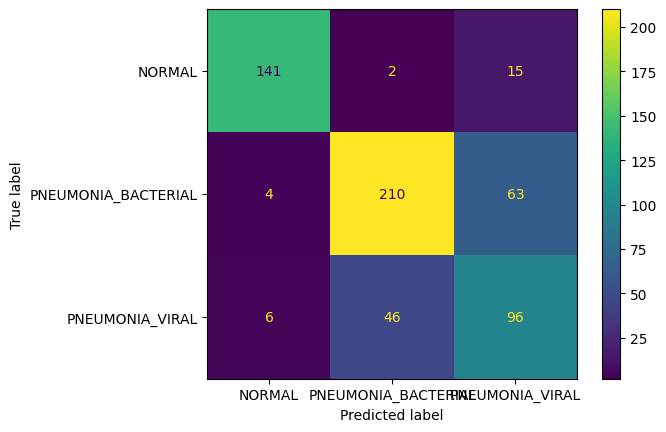

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 35ms/step - accuracy: 0.4740 - loss: 1.0553 - val_accuracy: 0.4734 - val_loss: 0.9852
Epoch 2/50
83/83 - 1s - 14ms/step - accuracy: 0.6336 - loss: 0.8171 - val_accuracy: 0.6913 - val_loss: 0.6906
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.7165 - loss: 0.6371 - val_accuracy: 0.7410 - val_loss: 0.5856
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.7481 - loss: 0.5918 - val_accuracy: 0.7307 - val_loss: 0.6435
Epoch 5/50
83/83 - 1s - 16ms/step - accuracy: 0.7472 - loss: 0.5896 - val_accuracy: 0.7599 - val_loss: 0.5548
Epoch 6/50
83/83 - 1s - 15ms/step - accuracy: 0.7480 - loss: 0.5930 - val_accuracy: 0.7822 - val_loss: 0.5177
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7763 - loss: 0.5445 - val_accuracy: 0.7907 - val_loss: 0.5017
Epoch 8/50
83/83 - 1s - 16ms/step - accuracy: 0.7880 - loss: 0.5123 - val_accuracy: 0.7633 - val_loss: 0.5379
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.7876 - loss: 0.5139 - val_accuracy: 0.7959 - val_loss: 0.4936
Epoch

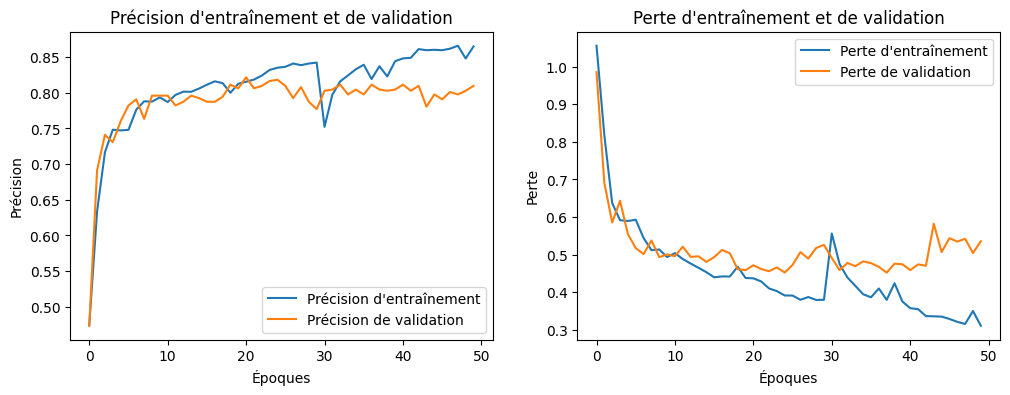

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8696 - loss: 0.3961
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Partition numéro 5:
perte: 0.54 précision: 0.81
AUC 0.9177
Prédictions
Counter({np.int64(1): 312, np.int64(0): 155, np.int64(2): 116}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.93      0.91      0.92       158
Pneumonia_bacteriana       0.79      0.89      0.84       277
     Pneumonia_viral       0.71      0.55      0.62       148

            accuracy                           0.81       583
           macro avg       0.81      0.78      0.79       583
        weighted avg       0.81      0.81      0.80       583

Matrice de confusion


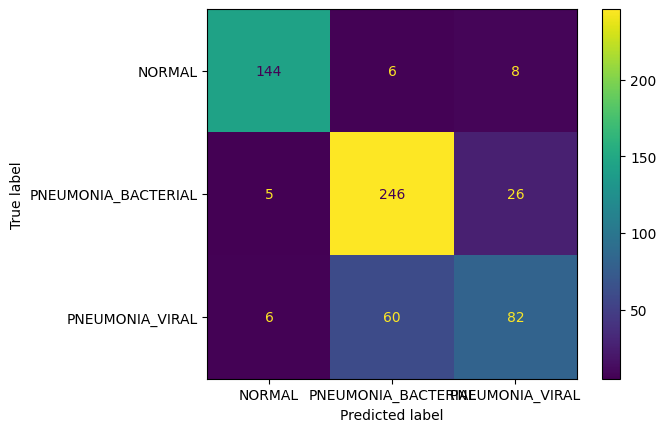

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 4s - 44ms/step - accuracy: 0.4991 - loss: 1.0245 - val_accuracy: 0.5472 - val_loss: 0.9507
Epoch 2/50
83/83 - 1s - 15ms/step - accuracy: 0.6586 - loss: 0.7728 - val_accuracy: 0.7136 - val_loss: 0.6589
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.7226 - loss: 0.6517 - val_accuracy: 0.7513 - val_loss: 0.5753
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.7540 - loss: 0.5968 - val_accuracy: 0.6930 - val_loss: 0.7480
Epoch 5/50
83/83 - 1s - 17ms/step - accuracy: 0.7375 - loss: 0.6279 - val_accuracy: 0.7684 - val_loss: 0.5620
Epoch 6/50
83/83 - 1s - 16ms/step - accuracy: 0.7741 - loss: 0.5486 - val_accuracy: 0.7804 - val_loss: 0.5346
Epoch 7/50
83/83 - 1s - 16ms/step - accuracy: 0.7821 - loss: 0.5214 - val_accuracy: 0.7753 - val_loss: 0.5387
Epoch 8/50
83/83 - 1s - 15ms/step - accuracy: 0.7870 - loss: 0.5091 - val_accuracy: 0.7530 - val_loss: 0.5729
Epoch 9/50
83/83 - 1s - 16ms/step - accuracy: 0.7925 - loss: 0.4999 - val_accuracy: 0.7804 - val_loss: 0.5089
Epoch

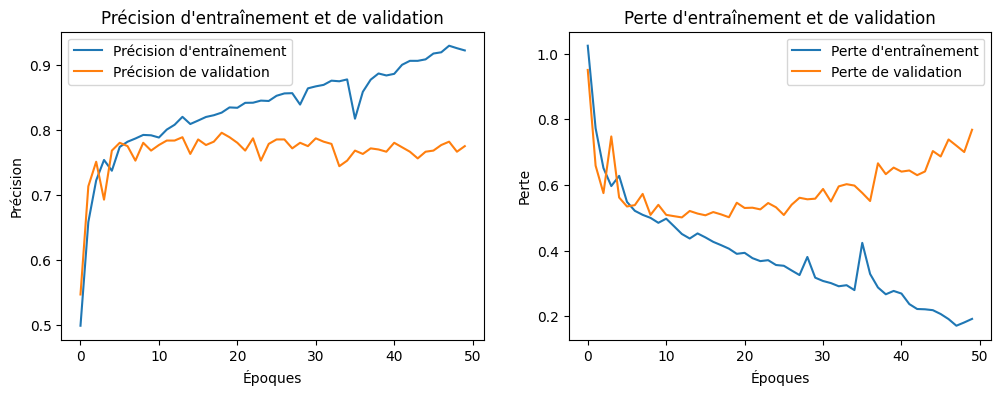

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8358 - loss: 0.5767 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 6:
perte: 0.77 précision: 0.78
AUC 0.9024
Prédictions
Counter({np.int64(1): 279, np.int64(0): 155, np.int64(2): 149}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.93      0.92      0.92       157
Pneumonia_bacteriana       0.79      0.79      0.79       278
     Pneumonia_viral       0.58      0.59      0.59       148

            accuracy                           0.78       583
           macro avg       0.77      0.77      0.77       583
        weighted avg       0.78      0.78      0.78       583

Matrice de confusion


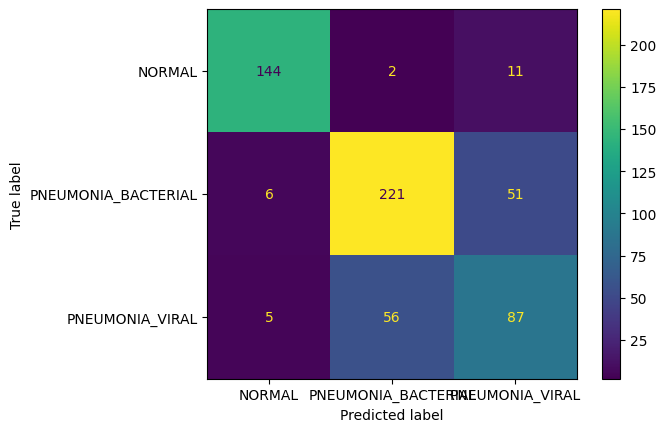

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 38ms/step - accuracy: 0.4885 - loss: 1.0492 - val_accuracy: 0.5626 - val_loss: 0.9585
Epoch 2/50
83/83 - 1s - 15ms/step - accuracy: 0.6510 - loss: 0.7875 - val_accuracy: 0.6844 - val_loss: 0.6884
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.7226 - loss: 0.6325 - val_accuracy: 0.7204 - val_loss: 0.6036
Epoch 4/50
83/83 - 1s - 15ms/step - accuracy: 0.7451 - loss: 0.5915 - val_accuracy: 0.7513 - val_loss: 0.5698
Epoch 5/50
83/83 - 1s - 16ms/step - accuracy: 0.7580 - loss: 0.5593 - val_accuracy: 0.7513 - val_loss: 0.5658
Epoch 6/50
83/83 - 1s - 16ms/step - accuracy: 0.7617 - loss: 0.5463 - val_accuracy: 0.7444 - val_loss: 0.5590
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7885 - loss: 0.5150 - val_accuracy: 0.7581 - val_loss: 0.5384
Epoch 8/50
83/83 - 1s - 16ms/step - accuracy: 0.7830 - loss: 0.5221 - val_accuracy: 0.7787 - val_loss: 0.5452
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.7840 - loss: 0.5056 - val_accuracy: 0.7719 - val_loss: 0.5292
Epoch

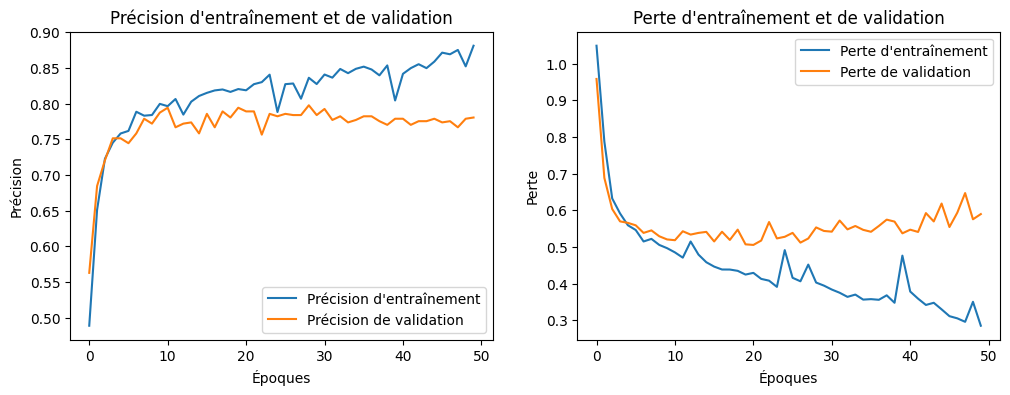

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8385 - loss: 0.5003
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 7:
perte: 0.59 précision: 0.78
AUC 0.9086
Prédictions
Counter({np.int64(1): 292, np.int64(0): 154, np.int64(2): 137}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.90      0.89      0.89       157
Pneumonia_bacteriana       0.79      0.83      0.81       278
     Pneumonia_viral       0.62      0.57      0.60       148

            accuracy                           0.78       583
           macro avg       0.77      0.76      0.77       583
        weighted avg       0.78      0.78      0.78       583

Matrice de confusion


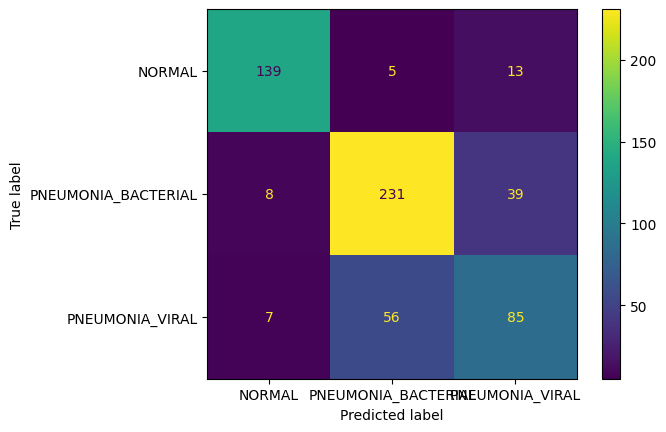

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 37ms/step - accuracy: 0.4694 - loss: 1.0623 - val_accuracy: 0.4751 - val_loss: 1.0487
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.6121 - loss: 0.8541 - val_accuracy: 0.6827 - val_loss: 0.6882
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.7066 - loss: 0.6621 - val_accuracy: 0.7084 - val_loss: 0.6411
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.7363 - loss: 0.6009 - val_accuracy: 0.7667 - val_loss: 0.5408
Epoch 5/50
83/83 - 1s - 15ms/step - accuracy: 0.7590 - loss: 0.5631 - val_accuracy: 0.8045 - val_loss: 0.4912
Epoch 6/50
83/83 - 1s - 16ms/step - accuracy: 0.7643 - loss: 0.5512 - val_accuracy: 0.8130 - val_loss: 0.4931
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7752 - loss: 0.5262 - val_accuracy: 0.8165 - val_loss: 0.4994
Epoch 8/50
83/83 - 1s - 16ms/step - accuracy: 0.7678 - loss: 0.5346 - val_accuracy: 0.8182 - val_loss: 0.4863
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.7861 - loss: 0.5077 - val_accuracy: 0.8062 - val_loss: 0.4650
Epoch

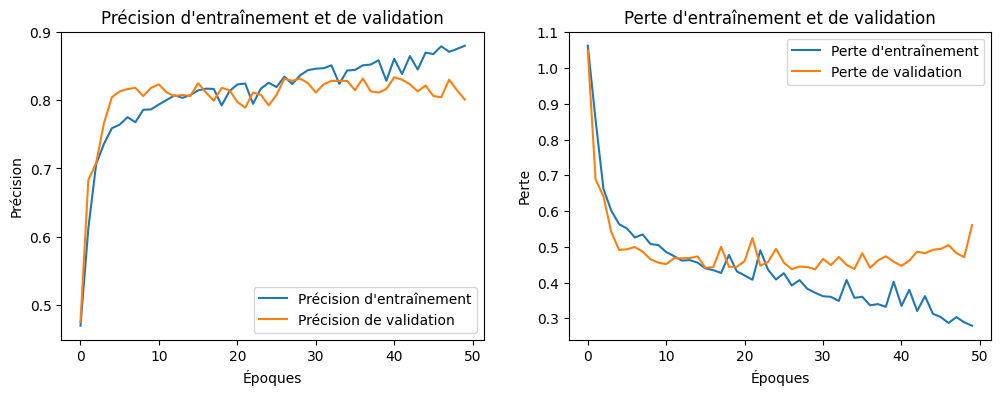

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8575 - loss: 0.4102
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 8:
perte: 0.56 précision: 0.80
AUC 0.9195
Prédictions
Counter({np.int64(1): 282, np.int64(0): 157, np.int64(2): 144}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.92      0.92      0.92       157
Pneumonia_bacteriana       0.81      0.82      0.82       277
     Pneumonia_viral       0.66      0.64      0.65       149

            accuracy                           0.80       583
           macro avg       0.80      0.79      0.79       583
        weighted avg       0.80      0.80      0.80       583

Matrice de confusion


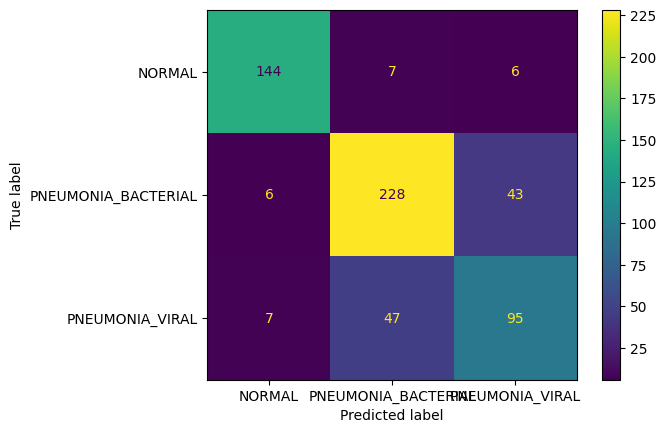

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 39ms/step - accuracy: 0.4730 - loss: 1.0622 - val_accuracy: 0.4751 - val_loss: 1.0226
Epoch 2/50
83/83 - 1s - 17ms/step - accuracy: 0.6104 - loss: 0.8520 - val_accuracy: 0.7204 - val_loss: 0.6736
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.7100 - loss: 0.6624 - val_accuracy: 0.7273 - val_loss: 0.6211
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.7401 - loss: 0.6033 - val_accuracy: 0.7719 - val_loss: 0.5318
Epoch 5/50
83/83 - 1s - 16ms/step - accuracy: 0.7592 - loss: 0.5571 - val_accuracy: 0.7633 - val_loss: 0.5419
Epoch 6/50
83/83 - 1s - 16ms/step - accuracy: 0.7725 - loss: 0.5420 - val_accuracy: 0.7822 - val_loss: 0.5120
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7828 - loss: 0.5124 - val_accuracy: 0.7736 - val_loss: 0.5077
Epoch 8/50
83/83 - 1s - 18ms/step - accuracy: 0.7851 - loss: 0.5028 - val_accuracy: 0.7822 - val_loss: 0.5082
Epoch 9/50
83/83 - 1s - 16ms/step - accuracy: 0.7874 - loss: 0.5032 - val_accuracy: 0.8027 - val_loss: 0.4816
Epoch

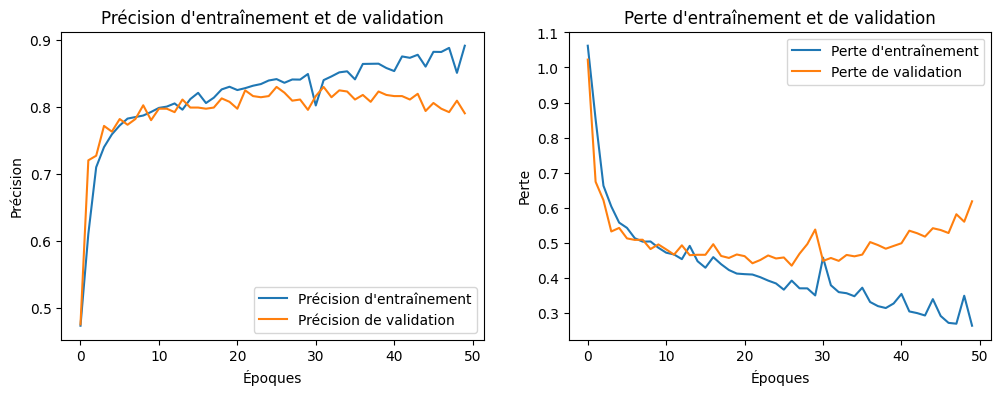

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8614 - loss: 0.4049
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Partition numéro 9:
perte: 0.62 précision: 0.79
AUC 0.9160
Prédictions
Counter({np.int64(1): 258, np.int64(0): 174, np.int64(2): 151}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.88      0.97      0.92       157
Pneumonia_bacteriana       0.83      0.78      0.80       277
     Pneumonia_viral       0.62      0.62      0.62       149

            accuracy                           0.79       583
           macro avg       0.78      0.79      0.78       583
        weighted avg       0.79      0.79      0.79       583

Matrice de confusion


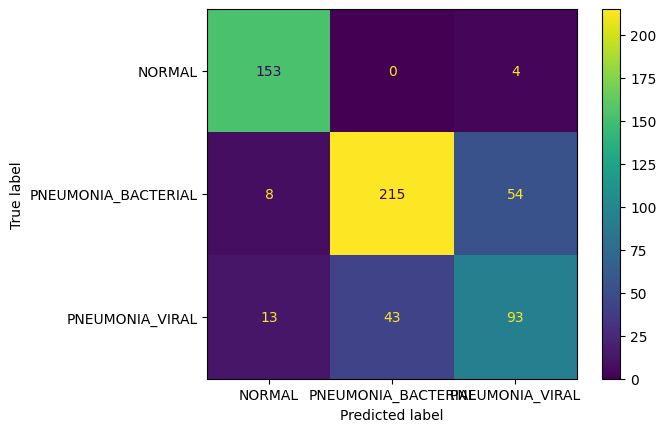

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 39ms/step - accuracy: 0.5039 - loss: 1.0156 - val_accuracy: 0.5472 - val_loss: 0.9183
Epoch 2/50
83/83 - 1s - 17ms/step - accuracy: 0.6750 - loss: 0.7341 - val_accuracy: 0.6792 - val_loss: 0.6939
Epoch 3/50
83/83 - 1s - 16ms/step - accuracy: 0.7203 - loss: 0.6308 - val_accuracy: 0.6604 - val_loss: 0.8075
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.7114 - loss: 0.6584 - val_accuracy: 0.7444 - val_loss: 0.5799
Epoch 5/50
83/83 - 1s - 17ms/step - accuracy: 0.7600 - loss: 0.5724 - val_accuracy: 0.7290 - val_loss: 0.5791
Epoch 6/50
83/83 - 1s - 16ms/step - accuracy: 0.7596 - loss: 0.5579 - val_accuracy: 0.7753 - val_loss: 0.5378
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7727 - loss: 0.5313 - val_accuracy: 0.7667 - val_loss: 0.5305
Epoch 8/50
83/83 - 1s - 16ms/step - accuracy: 0.7803 - loss: 0.5216 - val_accuracy: 0.7753 - val_loss: 0.5255
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.7897 - loss: 0.5022 - val_accuracy: 0.7890 - val_loss: 0.5096
Epoch

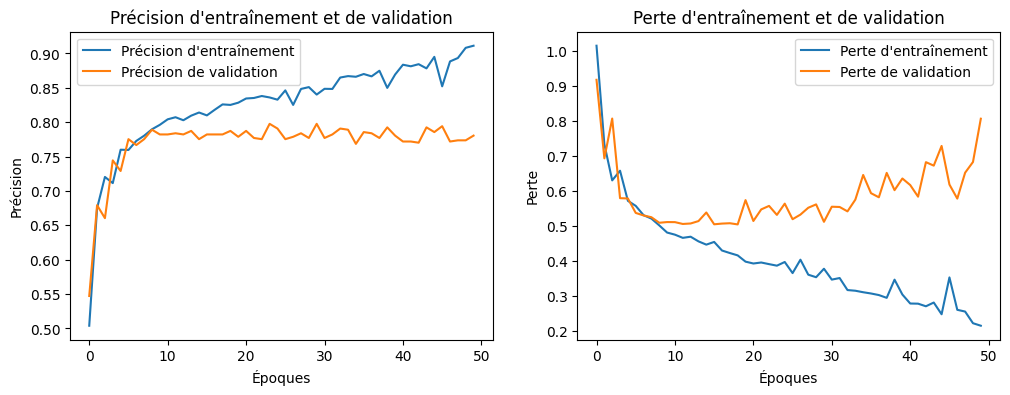

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8564 - loss: 0.5220
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 10:
perte: 0.81 précision: 0.78
AUC 0.9007
Prédictions
Counter({np.int64(1): 282, np.int64(0): 178, np.int64(2): 123}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.84      0.95      0.89       157
Pneumonia_bacteriana       0.80      0.81      0.81       277
     Pneumonia_viral       0.66      0.54      0.60       149

            accuracy                           0.78       583
           macro avg       0.76      0.77      0.76       583
        weighted avg       0.77      0.78      0.77       583

Matrice de confusion


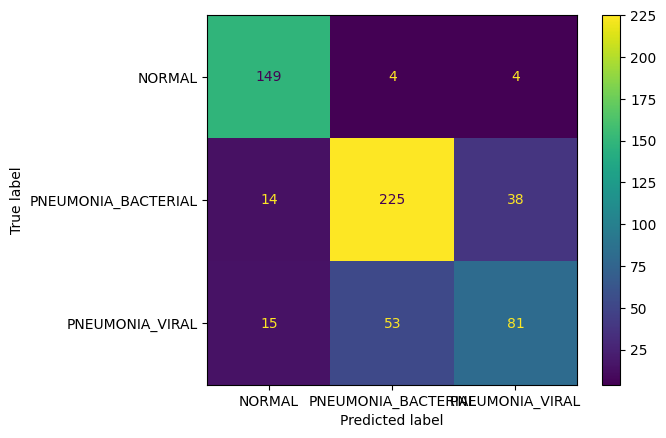

Le meilleur modèle a été sauvegardé avec un ROC de: 0.922611488704914
Fin de l'entraînement
Résultats ROC:
0.922611488704914

0.9169216633824067

0.9127081196457603

0.9131710885026986

0.9176925605469312

0.902380556900806

0.9085904215274488

0.9194568968473117

0.9160102193775795

0.9006577271851146

Tableau enregistré avec succès dans 'resultatsROC_2_2.txt'


In [11]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = charger_images_par_format_cv2(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    #90% train | 10% test
    for train_index, test_index in kf.split(X, y):
        # Division des données en ensemble d'entraînement et de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Informations sur les dimensions des données
        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        # Création du modèle
        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        # Compilation du modèle
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entraînement du modèle directement avec les données
        history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_test, y_test), 
            verbose=2)
        
        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia_bacteriana', 'Pneumonia_viral']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA_BACTERIAL','PNEUMONIA_VIRAL']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc_2_2.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "resultatsROC_2_2.txt")

if __name__ == '__main__':
    path_save_32x32=r"..\data\processed\images_32x32"
    main(path_save_32x32)
